# __Análisis bibliométrico empleando SPARK y técnicas de HPC para la búsqueda de moléculas con potencial inhibitorio de la proteasa principal del SARS-CoV-2__

---

Estudio de enfoque cuantitativo y bibliométrica en el que se recolectaron todas las publicaciones científicas relacionadas a moléculas con potencial inhibitorio de la proteasa principal del SARS-CoV-2 y disponibles en el dataset CORD-19. Se utilizó el framework PySpark el lenguaje de programación Phyton. Los archivos JSON del CORD-19 se cargaron en un Jupyter Notebook con el uso de la librería glob, para luego ser leído por medio de la función spark.read.json 
https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge

__Asesor:__

* Juan Sebastian Mejia

__Integrantes:__

* Moises Stevend Meza Rodriguez
* Jesus Antonio Alvarado Huayhuaz
* William Javier Araujo Banchón

In [160]:
!pip install graphviz

Defaulting to user installation because normal site-packages is not writeable


* * *

## Importación de librerias 

In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import pandas as pd
import glob
import json
import matplotlib.pyplot as plt
from pathlib import Path

## Creación de sesión en spark y lectura de base de datos

In [2]:
spark = (
    SparkSession.builder.appName("covid-grupo5")
    .master("local[*]")
    .config("spark.driver.memory", "32g")
    .config("spark.executor.memory", "32g")
    .config("spark.driver.maxResultSize", "16g")
    
    .getOrCreate()
)

21/08/27 02:16:32 WARN Utils: Your hostname, stevend-System-Product-Name resolves to a loopback address: 127.0.1.1; using 192.168.0.9 instead (on interface enp7s0)
21/08/27 02:16:32 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
21/08/27 02:16:33 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
21/08/27 02:16:34 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
path="/home/stevend/Documents/proyecto_spark_grupo5/dataset/"
root_path = Path(path)

all_json = glob.glob( str(root_path) + '/**/*.json', recursive=True) # path 

In [4]:
papers = spark.read.json(all_json, multiLine=True)

21/08/27 02:17:02 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


In [5]:
def concatenate_text(j):
    txt_all = ""
    try:
        for a in j:
            txt_all = txt_all + " " + a['text']
        return txt_all
    except:
        return ""

udf_concatenate_text = udf(concatenate_text)

papers_s = papers.select(papers['Paper_ID'], papers['metadata']['title'],  papers['metadata']['authors'],udf_concatenate_text(papers['body_text']))

In [6]:
papers_s.printSchema()

root
 |-- Paper_ID: string (nullable = true)
 |-- metadata.title: string (nullable = true)
 |-- metadata.authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- affiliation: struct (nullable = true)
 |    |    |    |-- institution: string (nullable = true)
 |    |    |    |-- laboratory: string (nullable = true)
 |    |    |    |-- location: struct (nullable = true)
 |    |    |    |    |-- addrLine: string (nullable = true)
 |    |    |    |    |-- country: string (nullable = true)
 |    |    |    |    |-- postBox: string (nullable = true)
 |    |    |    |    |-- postCode: string (nullable = true)
 |    |    |    |    |-- region: string (nullable = true)
 |    |    |    |    |-- settlement: string (nullable = true)
 |    |    |-- email: string (nullable = true)
 |    |    |-- first: string (nullable = true)
 |    |    |-- last: string (nullable = true)
 |    |    |-- middle: array (nullable = true)
 |    |    |    |-- element: string (containsN

In [7]:
papers_s.show()

+--------------------+--------------------+--------------------+---------------------------+
|            Paper_ID|      metadata.title|    metadata.authors|concatenate_text(body_text)|
+--------------------+--------------------+--------------------+---------------------------+
|          PMC2799006|21st ESICM Annual...|                  []|        After subarachno...|
|          PMC2799007|21st ESICM Annual...|                  []|        Cardiac Arrest (...|
|021fb6e79ff9c699f...|Designing Novel S...|[{{null, null, nu...|        Therapeutic prin...|
|02243452115108248...|Endogenous Opiate...|[{{University of ...|        ALMOST 20 years ...|
|02e359329ec030452...|The 15th Congress...|[{{null, null, nu...|        All sessions wil...|
|01377d0ab2e78372b...|Developing Recomb...|[{{null, null, nu...|        Antibodies are i...|
|011d10dc7d0696923...| Infectious diseases|                  []|        Many viruses inf...|
|          PMC1215526|Macrophages and c...|[{{null, null, nu...|      

In [8]:
papers_s = papers_s.withColumnRenamed('metadata.title', 'title')\
        .withColumnRenamed('metadata.authors', 'authors_info')\
        .withColumnRenamed('concatenate_text(body_text)', 'body')

In [9]:
papers_s.show()

+--------------------+--------------------+--------------------+--------------------+
|            Paper_ID|               title|        authors_info|                body|
+--------------------+--------------------+--------------------+--------------------+
|          PMC2799006|21st ESICM Annual...|                  []| After subarachno...|
|          PMC2799007|21st ESICM Annual...|                  []| Cardiac Arrest (...|
|021fb6e79ff9c699f...|Designing Novel S...|[{{null, null, nu...| Therapeutic prin...|
|02243452115108248...|Endogenous Opiate...|[{{University of ...| ALMOST 20 years ...|
|02e359329ec030452...|The 15th Congress...|[{{null, null, nu...| All sessions wil...|
|01377d0ab2e78372b...|Developing Recomb...|[{{null, null, nu...| Antibodies are i...|
|011d10dc7d0696923...| Infectious diseases|                  []| Many viruses inf...|
|          PMC1215526|Macrophages and c...|[{{null, null, nu...| Virus-host inter...|
|01d00b9170a73c234...|Interplay of Good...|[{{null, nu

## __Busqueda de Palabras en la base de datos de CORD-19__

In [10]:
filtros = {
    "corona_proteasa": [
        "Coronavirus 3C Proteases",
        "M(pro) Protein, Coronavirus",
        "Chymotrypsin-Like Main Protease, Coronavirus",
        "Chymotrypsin Like Main Protease, Coronavirus",
        "Coronavirus 3C-Like Proteinase",
        "Coronavirus 3C Proteinases",
        "Coronavirus 3CLpro Proteinase",
        "Coronavirus 3CLpro Proteases",
        "Coronavirus Mpro Protein",
        "Coronavirus Main Proteinase"
    ],
    "molecular_docking_simulation":[
        "Molecular Docking Simulation",
        "Molecular Docking Simulations",
        "Molecular Docking",
        "Molecular Dockings",
        "Molecular Docking Analysis",
        "Molecular Docking Analyses"
    ],
    "molecular_dynamics_simulation":[
        "Molecular Dynamics Simulation",
        "Molecular Dynamics Simulations",
        "Molecular Dynamics",
        "Molecular Dynamic"
    ],
    "machine_learning":[
        "Machine Learning",
        "Transfer Learning"
    ],
    "deep_learning":[
        "Deep Learning",
        "Hierarchical Learning",
        "deep neuronal networks",
        "neuronal networks"
    ],
    "pharmacokinetics":[ 
        "Pharmacokinetics",
        "Drug Kinetics",
        "ADMET",
        "ADME-Tox",
        "Absorption, Distribution, Metabolism, Elimination, and Toxicology",
        "LADMER",
        #"potential"
    ]
}

__conversión a minusculas de los filtros para CORD-19__

In [11]:
for i,j in zip(filtros.keys(),list(map(lambda x: [i.lower() for i in x] , filtros.values()))):
    filtros[i]=j

In [12]:
orden_filtros = {
    0:"corona_proteasa", 
    1:"molecular_docking_simulation", 
    2:"molecular_dynamics_simulation", 
    3:"machine_learning", 
    4:"deep_learning", 
    5:"pharmacokinetics"
}

#### Ordenamiento de los filtros a aplicar

Orden de ejecución:

__Filtro1 :__
* corona_proteasa
* molecular_docking_simulation
* molecular_dynamics_simulation
* pharmacokinetics

__Filtro2:__

* machine_learning
* deep_learning

In [13]:
filtro1 = [0,1,2,5]
filtro2 = [3,4]

### Función de busqueda de palabras en los datasets

In [22]:
states_body = papers_s.select(papers_s.body).toPandas()['body']
states_Paper_ID = papers_s.select(papers_s.Paper_ID).toPandas()['Paper_ID']

In [177]:
def funcion_filtro(states_title_, states_Paper_ID_, sord_orden_filtros):
    #global states_title
    #global states_Paper_ID
    global orden_filtros
    global filtros
    
    for cuenta, articulo in enumerate(zip(states_title_, states_Paper_ID_)):
        #for j in range(len(orden_filtros.keys())):
        for j in sord_orden_filtros:
            for z in filtros[orden_filtros[j]]:
                if z in articulo[0].lower():
                    yield articulo[0],articulo[1]
                    break

## Aplicación de los filtros solo para los bodys

In [178]:
filtro1_list = list(funcion_filtro(states_body, states_Paper_ID, filtro1))  

#print("BODY: Se encontro ",len(filtro1_list), "articulos en el filtro1")

filtro1_list_unzip = list(zip(*filtro1_list))

df1 = dict()

df1["body"] = filtro1_list_unzip[0]
df1["ID"] = filtro1_list_unzip[1]

#pd.DataFrame(df1).to_csv(f"./body_filtro1_{n}.csv", index=False)

In [39]:
tabla_merge = pd.DataFrame(df1)
tabla_merge.head()

,body,ID
0,Therapeutic principles established in non-hum...,021fb6e79ff9c699f5f7e1b59f722297252870c9
1,All sessions will take place at the Hilton Ne...,02e359329ec03045275aaf6a153b97dc4e0866af
2,SARS-CoV-2 was initially recognized and desig...,00faf3c13ba7ab95fbd7e8751c1570e26f5975f3
3,There are currently about 132 therapeutic age...,01d985de3be48744c128a1710dfdafdad99af84d
4,There are currently about 132 therapeutic age...,01d985de3be48744c128a1710dfdafdad99af84d


# Tratamiento de metadatos

In [26]:
tabla = pd.read_csv("./metadata.csv")
tabla.head()

/home/stevend/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3169: DtypeWarning: Columns (1,4,5,6,13,14,15,16) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [27]:
columnas_importantes = ["sha", "source_x", "title", "pmcid","license","publish_time","journal"]

In [28]:
tabla_f =  tabla[columnas_importantes]

In [29]:
tabla_f.publish_time = tabla_f.publish_time.astype('datetime64[ns]')

/usr/local/lib/python3.8/dist-packages/pandas/core/generic.py:5489: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [32]:
!pip install missingno

Defaulting to user installation because normal site-packages is not writeable


In [33]:
import missingno as msno

<AxesSubplot:>

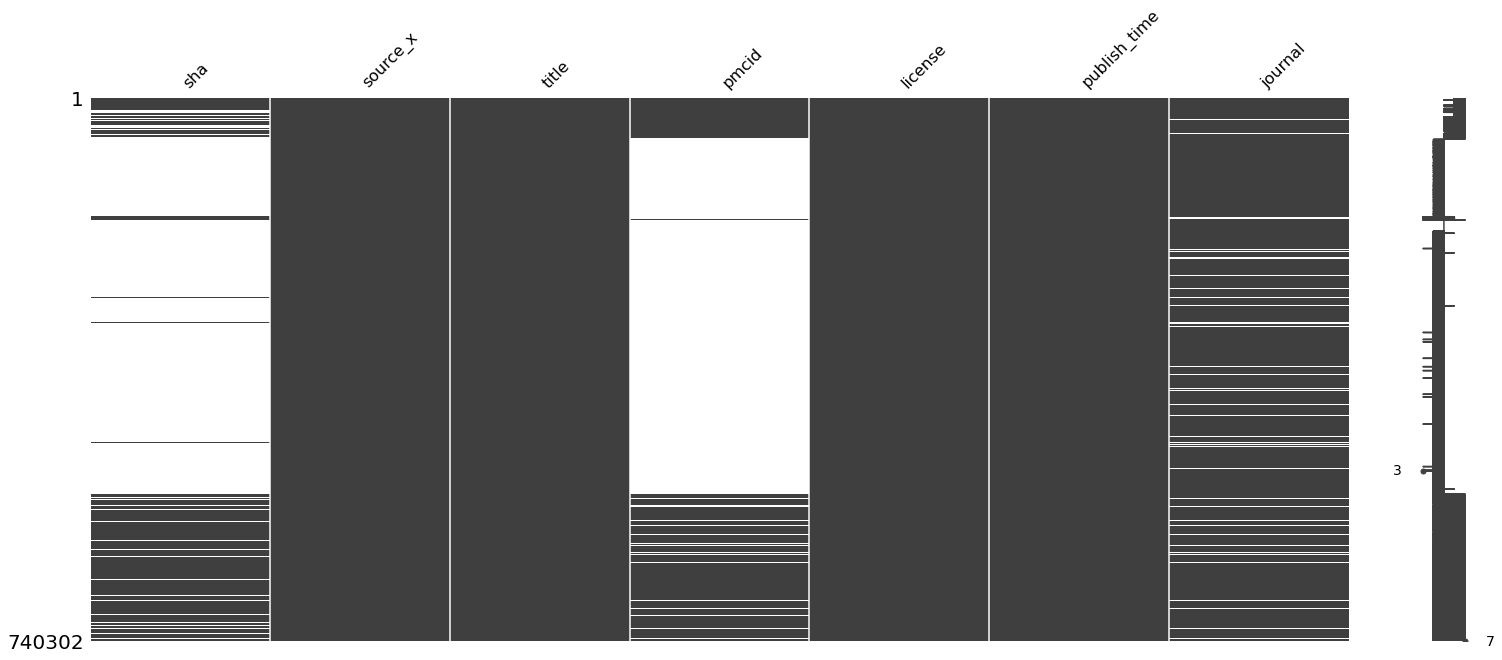

In [34]:
msno.matrix(tabla_f)

In [35]:
tabla_f.head()

,sha,source_x,title,pmcid,license,publish_time,journal
0,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,PMC35282,no-cc,2001-07-04,BMC Infect Dis
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,PMC59543,no-cc,2000-08-15,Respir Res
2,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,PMC59549,no-cc,2000-08-25,Respir Res
3,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,PMC59574,no-cc,2001-02-22,Respir Res
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,PMC59580,no-cc,2001-05-11,Respir Res


In [36]:
tabla_metadatos_f1 = tabla_f[(tabla_f["sha"].notnull()) | (tabla_f["pmcid"].notnull())]

In [37]:
tabla_metadatos_f1.head()

,sha,source_x,title,pmcid,license,publish_time,journal
0,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,PMC35282,no-cc,2001-07-04,BMC Infect Dis
1,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,PMC59543,no-cc,2000-08-15,Respir Res
2,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,PMC59549,no-cc,2000-08-25,Respir Res
3,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,PMC59574,no-cc,2001-02-22,Respir Res
4,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,PMC59580,no-cc,2001-05-11,Respir Res


# Combinación de dataset CORD-19 y metadatos

In [40]:
tabla_merge["sha"]=tabla_merge.ID

In [41]:
tabla_sha = pd.merge(tabla_metadatos_f1, tabla_merge, on="sha", how="inner")

In [43]:
tabla_merge["pmcid"]=tabla_merge.ID

In [45]:
tabla_pmcid = pd.merge(tabla_metadatos_f1, tabla_merge, on="pmcid", how="inner")

In [46]:
tabla_sha

,sha,source_x,title,pmcid,license,publish_time,journal,body,ID
0,0304ed96b29c38014a17bacefcc294a02c04d0a0,PMC,Statistical Evaluation of HTS Assays for Enzym...,PMC4711668,cc-by,2016-01-05,PLoS One,Introduction β-amino acids are intermediates ...,0304ed96b29c38014a17bacefcc294a02c04d0a0
1,0231e91dbdf6a9e93b6816f535331328e54982ed,PMC,Clinical Pharmacological and Therapeutic Consi...,PMC7101565,no-cc,2012-10-23,Drugs,of prophylactic and therapeutic drug treatmen...,0231e91dbdf6a9e93b6816f535331328e54982ed
2,00a92808a365d7f1fb9cbf7f64ac953e71e9d71b,PMC,Computational target-based drug repurposing of...,PMC7263767,cc-by-nc-nd,2020-04-08,ChemRxiv,The COVID-19 pandemic has created an urgent n...,00a92808a365d7f1fb9cbf7f64ac953e71e9d71b
3,029f6edcb4c385ef03923e35119d99c08c43497c,PMC,Ansuvimab: First Approval,PMC7983082,no-cc,2021-03-22,Drugs,Ebola virus disease is a potentially fatal di...,029f6edcb4c385ef03923e35119d99c08c43497c
4,0005d592db6946c5e2612c29420f3fe7cd53c952,PMC,Berberine in Human Oncogenic Herpesvirus Infec...,PMC8229678,cc-by,2021-05-28,Viruses,Herpesviruses are a diverse group of large do...,0005d592db6946c5e2612c29420f3fe7cd53c952
...,...,...,...,...,...,...,...,...,...
87,020d0dce89fe3475e56a42dffa61476d1588c7f4,Elsevier; Medline; PMC,"Molecular docking, molecular dynamics, and in ...",PMC7713577,no-cc,2020-12-03,Heliyon,"By December 2019, a novel coronavirus, SARS-C...",020d0dce89fe3475e56a42dffa61476d1588c7f4
88,021cd9318b74a2b61788a04f7c6f3da88adde21f,BioRxiv; WHO,S-acylation controls SARS-Cov-2 membrane lipid...,NaN,biorxiv,2021-03-15,bioRxiv,β-Coronaviruses (CoVs) belong to a family of ...,021cd9318b74a2b61788a04f7c6f3da88adde21f
89,008fd0d0ac89ab53db8c65f2385b8857600b2a3a,Medline; PMC,Application of Fragment-Based Drug Discovery t...,PMC7419598,cc-by,2020-08-05,Front Mol Biosci,Fragment-based drug design (FBDD) is an appro...,008fd0d0ac89ab53db8c65f2385b8857600b2a3a
90,01f1cdd9bf4b6c1e5c768931071b6aca44399b29,Medline; PMC,Targeting the glycan of receptor binding domai...,PMC7540766,cc-by,2020-09-23,R Soc Open Sci,Coronavirus (CoV) belongs to a family of enve...,01f1cdd9bf4b6c1e5c768931071b6aca44399b29


In [47]:
tabla_pmcid

,sha_x,source_x,title,pmcid,license,publish_time,journal,body,ID,sha_y
0,c1ad13d83e926979dbf2bbe52e4944082f28dfea,PMC,Antisense-induced ribosomal frameshifting,PMC1616946,cc-by-nc,2006-08-18,Nucleic Acids Res,The standard triplet readout of the genetic c...,PMC1616946,PMC1616946
1,ad9ac0ac5e7da097253fd545b56e2b15ee9de34f; daee...,PMC,Molecular dynamics simulations of human [Formu...,PMC1636460,cc-by-nc,2006-09-29,Nucleic Acids Res,Nonstandard bases are most prevalently found ...,PMC1636460,PMC1636460
2,b3ab47699907f78c2ac478d06f682f56fa0cf351,PMC,Bench-to-bedside review: Critical illness-asso...,PMC1794449,no-cc,2006-11-15,Crit Care,"Since its advent more than 40 years ago, the ...",PMC1794449,PMC1794449
3,fcbb20fc325656ad86d5ed3e810cd0f4639ada77,PMC,Apoptotic signals induce specific degradation ...,PMC2396418,cc-by-nc,2008-04-01,Nucleic Acids Res,Gene expression in all organisms is regulated...,PMC2396418,PMC2396418
4,c60e9faaf8d025d3cf00b275de051fc9bc3b5bd4,PMC,Early transcriptional response in the jejunum ...,PMC2441536,no-cc,2008-06-04,Arch Virol,With an estimated death rate of more than 400...,PMC2441536,PMC2441536
5,9171d275fc9e9737e66cddd44c988e793270ff7c,PMC,Discovery and Development of Toll-Like Recepto...,PMC2469272,no-cc,2008-05-21,Pharm Res,Bacteria are classified into two groups based...,PMC2469272,PMC2469272
6,eb627ab77c71445ccc0b05f2193fe9289ac142ee,PMC,Protein Domain Boundary Predictions: A Structu...,PMC2669640,cc-by-nc,2009-01-21,Open Biochem J,"Computational/mathematical approaches, such a...",PMC2669640,PMC2669640
7,ec3316b6d33659c1070099a4395a1c25eeacc446,PMC,"Triple Combination of Amantadine, Ribavirin, a...",PMC2825274,cc0,2010-02-22,PLoS One,"Globally, influenza viruses cause substantial...",PMC2825274,PMC2825274
8,a4ee99345c99a1f9806c8d17dc7e6accaf5309d6,PMC,Peptide-Mediated Liposomal Drug Delivery Syste...,PMC2864512,cc-by,2010-05-05,J Oncol,One of the primary goals of a successful canc...,PMC2864512,PMC2864512
9,bc7b2271acba0248f021e9e11cb91cec6358d924,PMC,Assessing the human immune system through bloo...,PMC2895587,cc-by,2010-07-01,BMC Biol,The immune system plays a central role not on...,PMC2895587,PMC2895587


In [48]:
tabla_final = pd.merge(tabla_sha, tabla_pmcid, on="title", how="inner")

In [64]:
tabla_sha.columns

Index(['sha', 'source_x', 'title', 'pmcid', 'license', 'publish_time',
       'journal', 'body', 'ID'],
      dtype='object')

In [ ]:
tabla_final.to_csv("./dataset400k_filtrado.csv", index=False)

# Filtrado de tabla_final

In [3]:
tabla = pd.read_csv("./dataset400k_filtrado.csv")

In [4]:
tabla.shape

(10749, 19)

In [5]:
tabla.head(5)

,index_x,sha_x,source_x_x,title,pmcid_x,license_x,publish_time_x,journal_x,body_x,ID_x,index_y,sha_y,source_x_y,pmcid_y,license_y,publish_time_y,journal_y,body_y,ID_y
0,106109,4d71d3af9df364fb430ff69571ee354c3be7a3f6,BioRxiv,Structural basis of the activation of the CC c...,NaN,biorxiv,2020-11-27,bioRxiv,The human CC chemokine receptor 5 (CCR5) is a...,4d71d3af9df364fb430ff69571ee354c3be7a3f6,158307,e08aa7c2231fd68acad9e7f691193b286ce14b74,Medline; PMC,PMC8208711,cc-by-nc,2021-06-16,Sci Adv,The human CC chemokine receptor 5 (CCR5) is a...,PMC8208711
1,158307,e08aa7c2231fd68acad9e7f691193b286ce14b74,Medline; PMC,Structural basis of the activation of the CC c...,PMC8208711,cc-by-nc,2021-06-16,Sci Adv,The human CC chemokine receptor 5 (CCR5) is a...,e08aa7c2231fd68acad9e7f691193b286ce14b74,158307,e08aa7c2231fd68acad9e7f691193b286ce14b74,Medline; PMC,PMC8208711,cc-by-nc,2021-06-16,Sci Adv,The human CC chemokine receptor 5 (CCR5) is a...,PMC8208711
2,106240,299a7d86e207d2e4d3f3296fa7ff78f4cc2e6176,BioRxiv,Scalable Analysis of Authentic Viral Envelopes...,NaN,biorxiv,2020-07-06,bioRxiv,V IRUSES are pathogens that cause infectious ...,299a7d86e207d2e4d3f3296fa7ff78f4cc2e6176,58423,b3f50c7450c9cedd37ae913368741086f1b10d48,Medline; PMC,PMC7839976,cc-by-nc-nd,2020-08-31,Comput Sci Eng,MD simulations of membranes can be carried ou...,PMC7839976
3,58423,b3f50c7450c9cedd37ae913368741086f1b10d48,Medline; PMC,Scalable Analysis of Authentic Viral Envelopes...,PMC7839976,cc-by-nc-nd,2020-08-31,Comput Sci Eng,encoded as RNA or as DNA. More complex virus ...,b3f50c7450c9cedd37ae913368741086f1b10d48,58423,b3f50c7450c9cedd37ae913368741086f1b10d48,Medline; PMC,PMC7839976,cc-by-nc-nd,2020-08-31,Comput Sci Eng,MD simulations of membranes can be carried ou...,PMC7839976
4,107014,ecd49cc19bc2ce62c4ab06ec27b5e34757bd6e37,BioRxiv,PharmaNet: Pharmaceutical discovery with deep ...,NaN,biorxiv,2021-02-22,bioRxiv,The development and subsequent market penetra...,ecd49cc19bc2ce62c4ab06ec27b5e34757bd6e37,88185,92853bd47f44a640903d4c59659c2f56593b31f0,Medline; PMC,PMC8075191,cc-by,2021-04-26,PLoS One,The development and subsequent market penetra...,PMC8075191


In [6]:
tabla.columns

Index(['index_x', 'sha_x', 'source_x_x', 'title', 'pmcid_x', 'license_x',
       'publish_time_x', 'journal_x', 'body_x', 'ID_x', 'index_y', 'sha_y',
       'source_x_y', 'pmcid_y', 'license_y', 'publish_time_y', 'journal_y',
       'body_y', 'ID_y'],
      dtype='object')

In [7]:
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

In [8]:
tabla_title.head()

,title,0
0,Characterizing Eckol as a Therapeutic Aid: A S...,16
1,Molecular modeling of potent novel sulfonamide...,16
2,Virtual screening of anti-HIV1 compounds again...,16
3,Posters,16
4,"Predictive modeling by deep learning, virtual ...",16


In [9]:
title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
#title_unique_df = pd.DataFrame(title_unique, columns=tabla.columns)

In [10]:
title_unique_df = pd.DataFrame(title_unique, columns=tabla.columns)
title_unique_df.head()

,index_x,sha_x,source_x_x,title,pmcid_x,license_x,publish_time_x,journal_x,body_x,ID_x,index_y,sha_y,source_x_y,pmcid_y,license_y,publish_time_y,journal_y,body_y,ID_y
7588,168218,99f61ec3a18d65b10e7df69531368c3afae01e45,Medline; PMC,Characterizing Eckol as a Therapeutic Aid: A S...,PMC6627842,cc-by,2019-06-18,Mar Drugs,Seaweed refers to a diverse group of macrosco...,99f61ec3a18d65b10e7df69531368c3afae01e45,168218,99f61ec3a18d65b10e7df69531368c3afae01e45,Medline; PMC,PMC6627842,cc-by,2019-06-18,Mar Drugs,Seaweed refers to a diverse group of macrosco...,PMC6627842
1330,27320,8870bf6cd845e0512d61f080b866dedf5d3ed25f,Medline; PMC,Molecular modeling of potent novel sulfonamide...,PMC8171005,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,8870bf6cd845e0512d61f080b866dedf5d3ed25f,27320,8870bf6cd845e0512d61f080b866dedf5d3ed25f,Medline; PMC,PMC8171005,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,PMC8171005
6476,142751,9fbf4a06040e536c54cc4ab8c2148a53b9cc7bd9,Medline; PMC,Virtual screening of anti-HIV1 compounds again...,PMC7683650,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",9fbf4a06040e536c54cc4ab8c2148a53b9cc7bd9,142751,9fbf4a06040e536c54cc4ab8c2148a53b9cc7bd9,Medline; PMC,PMC7683650,cc-by,2020-11-23,Sci Rep,Severe Acute Respiratory Syndrome Coronavirus...,PMC7683650
868,18222,1df4d00fc76da33658ae7e6920bc25371be655a9,Medline; PMC,"Predictive modeling by deep learning, virtual ...",PMC7484589,no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",1df4d00fc76da33658ae7e6920bc25371be655a9,18222,1df4d00fc76da33658ae7e6920bc25371be655a9,Medline; PMC,PMC7484589,no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",PMC7484589
4892,109022,ad534a108cbc512e3b48b4786649cc595df7fa08,Elsevier; PMC,Prediction of Medicinal Properties Using Mathe...,PMC7149595,no-cc,2018-05-04,Computational Phytochemistry,Use of plant-based materials dates back to ea...,ad534a108cbc512e3b48b4786649cc595df7fa08,109022,ad534a108cbc512e3b48b4786649cc595df7fa08,Elsevier; PMC,PMC7149595,no-cc,2018-05-04,Computational Phytochemistry,Use of plant-based materials dates back to ea...,PMC7149595


In [11]:
title_unique_df = title_unique_df.reset_index()

In [12]:
#title_unique_df.to_csv("data_final.csv", index=False)

In [13]:
title_unique_df.title.value_counts()

A Novel SARS-CoV-2 Viral Sequence Bioinformatic Pipeline Has Found Genetic Evidence That the Viral 3′ Untranslated Region (UTR) Is Evolving and Generating Increased Viral Diversity                  1
Raltegravir, Indinavir, Tipranavir, Dolutegravir, and Etravirine against main protease and RNA-dependent RNA polymerase of SARS-CoV-2: A molecular docking and drug repurposing approach              1
Single-Molecular Förster Resonance Energy Transfer Measurement on Structures and Interactions of Biomolecules                                                                                         1
High-throughput screening of the ReFRAME, Pandemic Box, and COVID Box drug repurposing libraries against SARS-CoV-2 nsp15 endoribonuclease to identify small-molecule inhibitors of viral activity    1
Scutellaria baicalensis extract and baicalein inhibit replication of SARS-CoV-2 and its 3C-like protease in vitro                                                                                     1


# Analisis de la base de datos final

In [14]:
title_unique_df.columns

Index(['index', 'index_x', 'sha_x', 'source_x_x', 'title', 'pmcid_x',
       'license_x', 'publish_time_x', 'journal_x', 'body_x', 'ID_x', 'index_y',
       'sha_y', 'source_x_y', 'pmcid_y', 'license_y', 'publish_time_y',
       'journal_y', 'body_y', 'ID_y'],
      dtype='object')

In [15]:
try:
    l_title = ['title', 'license_x', 'publish_time_x', 'journal_x', 'body_x', 'source_x_y', ]
    data_final = title_unique_df[l_title]
except:
    l_title = ['title', 'license', 'publish_time', 'journal', 'body', 'source_x', ]
    data_final = title_unique_df[l_title]

In [16]:
data_final = title_unique_df[l_title]
data_final.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y
0,Characterizing Eckol as a Therapeutic Aid: A S...,cc-by,2019-06-18,Mar Drugs,Seaweed refers to a diverse group of macrosco...,Medline; PMC
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC
3,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC
4,Prediction of Medicinal Properties Using Mathe...,no-cc,2018-05-04,Computational Phytochemistry,Use of plant-based materials dates back to ea...,Elsevier; PMC


In [17]:
try:
    data_final["source_medline"] = data_final["source_x_y"].apply(lambda x: x.split(";")[0])
    l_aux2 = []

    for i in data_final.source_x_y:
        l_aux2.append(i)
    l_aux2_set =set(l_aux2)
    
except:
    data_final["source_medline"] = data_final["source_x"].apply(lambda x: x.split(";")[0])
    l_aux2 = []

    for i in data_final.source_x:
        l_aux2.append(i)
    l_aux2_set =set(l_aux2)

/tmp/ipykernel_634230/3730457562.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final["source_medline"] = data_final["source_x_y"].apply(lambda x: x.split(";")[0])


In [18]:
def split_text(ss):
    ss_aux = []
    for i in ss:
        ss_aux.extend(i.split(";"))
        
    return ss_aux

In [19]:
columns_source = list(set(list(map(lambda x: x.replace(" ","").lower(), set(split_text(l_aux2_set))))))
columns_source

['elsevier', 'who', 'biorxiv', 'pmc', 'arxiv', 'medline']

In [20]:
try:
    for i in columns_source:
        data_final[i] = data_final.source_x_y.apply(lambda x: 1 if (i in x.replace(" ","").lower()) else 0)
except:
    for i in columns_source:
        data_final[i] = data_final.source_x.apply(lambda x: 1 if (i in x.replace(" ","").lower()) else 0)

/tmp/ipykernel_634230/2611572029.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final[i] = data_final.source_x_y.apply(lambda x: 1 if (i in x.replace(" ","").lower()) else 0)


In [21]:
data_final.columns

Index(['title', 'license_x', 'publish_time_x', 'journal_x', 'body_x',
       'source_x_y', 'source_medline', 'elsevier', 'who', 'biorxiv', 'pmc',
       'arxiv', 'medline'],
      dtype='object')

In [22]:
data_final_final = data_final[data_final.columns]

In [23]:
data_final_final.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
0,Characterizing Eckol as a Therapeutic Aid: A S...,cc-by,2019-06-18,Mar Drugs,Seaweed refers to a diverse group of macrosco...,Medline; PMC,Medline,0,0,0,1,0,1
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
3,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1
4,Prediction of Medicinal Properties Using Mathe...,no-cc,2018-05-04,Computational Phytochemistry,Use of plant-based materials dates back to ea...,Elsevier; PMC,Elsevier,1,0,0,1,0,0


In [24]:
try:
    data_final_final["publish_time_x"] = data_final_final.publish_time_x.astype("datetime64[ns]")
except:
    data_final_final["publish_time"] = data_final_final.publish_time.astype("datetime64[ns]")

## Filtrado adicional

### filtros por fechas (>=2020)

In [25]:
data_final_final.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
0,Characterizing Eckol as a Therapeutic Aid: A S...,cc-by,2019-06-18,Mar Drugs,Seaweed refers to a diverse group of macrosco...,Medline; PMC,Medline,0,0,0,1,0,1
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
3,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1
4,Prediction of Medicinal Properties Using Mathe...,no-cc,2018-05-04,Computational Phytochemistry,Use of plant-based materials dates back to ea...,Elsevier; PMC,Elsevier,1,0,0,1,0,0


In [26]:
from datetime import datetime, date, time

In [27]:
data_final_final["publish_time_x"]

0      2019-06-18
1      2021-06-01
2      2020-11-23
3      2020-08-05
4      2018-05-04
          ...    
5465   2020-09-02
5466   2021-04-28
5467   2021-05-22
5468   2021-01-13
5469   2016-02-02
Name: publish_time_x, Length: 5470, dtype: datetime64[ns]

In [28]:
data_final_final = data_final_final[data_final_final["publish_time_x"] > datetime(2019,11,30)]
data_final_final.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
3,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1
5,In silico Screening of Natural Compounds as Po...,cc-by,2021-01-19,Front Mol Biosci,The World Health Organization (2020) declared...,Medline; PMC,Medline,0,0,0,1,0,1
6,An insight into the inhibitory mechanism of ph...,no-cc,2021-05-08,Chem Zvesti,The severe acute respiratory syndrome coronav...,Medline; PMC,Medline,0,0,0,1,0,1


In [29]:
data_final_final.shape

(4356, 13)

## palabra de coincidencia en el body (>=2 de diferentes criterios de busqueda)

### Filtrado por dataset de contenido sobre el COVID-19

In [30]:
data_final_final.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
3,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1
5,In silico Screening of Natural Compounds as Po...,cc-by,2021-01-19,Front Mol Biosci,The World Health Organization (2020) declared...,Medline; PMC,Medline,0,0,0,1,0,1
6,An insight into the inhibitory mechanism of ph...,no-cc,2021-05-08,Chem Zvesti,The severe acute respiratory syndrome coronav...,Medline; PMC,Medline,0,0,0,1,0,1


In [31]:
data_final_final.shape

(4356, 13)

In [32]:
filtros_data_final = {
    "corona_proteasa": [
        "Coronavirus 3C Proteases",
        "M(pro) Protein, Coronavirus",
        "Chymotrypsin-Like Main Protease, Coronavirus",
        "Chymotrypsin Like Main Protease, Coronavirus",
        "Coronavirus 3C-Like Proteinase",
        "Coronavirus 3C Proteinases",
        "Coronavirus 3CLpro Proteinase",
        "Coronavirus 3CLpro Proteases",
        "Coronavirus Mpro Protein",
        "Coronavirus Main Proteinase"
    ],
    "covid":[
        "covid-19",
        "covid19",
        "sars-cov-2",
        "sars",
        "coronavirus",
        "coronavirus deseasse",
        "pandemic",
        "covid"
    ],
}

In [33]:
orden_filtros = {
    0:"corona_proteasa", 
    1:"covid", 

}

filtro1 = [0,1]


In [34]:
for i,j in zip(filtros_data_final.keys(),list(map(lambda x: [i.lower() for i in x] , filtros_data_final.values()))):
    filtros_data_final[i]=j

In [35]:
def funcion_filtro_covid(states_body_, states_Paper_title_, sord_orden_filtros):
    #global states_title
    #global states_Paper_ID
    global orden_filtros
    global filtros
    
    for cuenta, articulo in enumerate(zip(states_body_, states_Paper_title_)):
        #for j in range(len(orden_filtros.keys())):
        for j in sord_orden_filtros:
            for z in filtros_data_final[orden_filtros[j]]:
                if z in articulo[0].lower():
                    yield articulo[0],articulo[1]
                    break

In [36]:
filtro_covid_list = list(funcion_filtro_covid(data_final_final.body_x, data_final_final.title, filtro1))  

In [37]:
print("TITLE: Se encontro ",len(filtro_covid_list), "articulos en el filtro1")

TITLE: Se encontro  3818 articulos en el filtro1


In [38]:
filtro1_list_unzip = list(zip(*filtro_covid_list))

In [39]:
df1 = dict()

df1["title"] = filtro1_list_unzip[1]

In [40]:
df_t = pd.DataFrame(df1)["title"]
df_t.head()

0    Molecular modeling of potent novel sulfonamide...
1    Molecular modeling of potent novel sulfonamide...
2    Virtual screening of anti-HIV1 compounds again...
3    Virtual screening of anti-HIV1 compounds again...
4    Predictive modeling by deep learning, virtual ...
Name: title, dtype: object

In [41]:
df_filtro_covid = pd.merge(df_t, data_final_final)
df_filtro_covid.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
0,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
1,Molecular modeling of potent novel sulfonamide...,no-cc,2021-06-01,Journal of biomolecular structure & dynamics,COVID19 has affected more than 15 million ind...,Medline; PMC,Medline,0,0,0,1,0,1
2,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
3,Virtual screening of anti-HIV1 compounds again...,cc-by,2020-11-23,Sci Rep,"Sequence similarity analysis, screening by th...",Medline; PMC,Medline,0,0,0,1,0,1
4,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1


In [42]:
tabla = df_filtro_covid

In [43]:
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

In [44]:
title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_covid = pd.DataFrame(title_unique, columns=tabla.columns)

In [45]:
df_filtro_covid.shape

(3790, 13)

### Filtrado por tematica del estudio

In [46]:
filtros_estudio = {
    "molecular_docking_simulation":[
        "Molecular Docking Simulation",
        "Molecular Docking Simulations",
        "Molecular Docking",
        "Molecular Dockings",
        "Molecular Docking Analysis",
        "Molecular Docking Analyses"
    ],
    "molecular_dynamics_simulation":[
        "Molecular Dynamics Simulation",
        "Molecular Dynamics Simulations",
        "Molecular Dynamics",
        "Molecular Dynamic"
    ],
    "pharmacokinetics":[ 
        "Pharmacokinetics",
        "Drug Kinetics",
        "ADMET",
        "ADME-Tox",
        "Absorption, Distribution, Metabolism, Elimination, and Toxicology",
        "LADMER",
        #"potential"
    ]
}


In [47]:
orden_filtros = {
    0:"molecular_docking_simulation", 
    1:"molecular_dynamics_simulation", 
    2:"pharmacokinetics"
}

filtro1_estudio = [0,1,2]


In [48]:
for i,j in zip(filtros_estudio.keys(),list(map(lambda x: [i.lower() for i in x] , filtros_estudio.values()))):
    filtros_estudio[i]=j

In [49]:
def funcion_filtro_estudio(states_body_, states_Paper_title_, sord_orden_filtros):
    #global states_title
    #global states_Paper_ID
    global orden_filtros
    global filtros
    
    for cuenta, articulo in enumerate(zip(states_body_, states_Paper_title_)):
        #for j in range(len(orden_filtros.keys())):
        for j in sord_orden_filtros:
            for z in filtros_estudio[orden_filtros[j]]:
                if z in articulo[0].lower():
                    yield articulo[0],articulo[1]
                    break

In [50]:
filtro_estudio_list = list(funcion_filtro_estudio(df_filtro_covid.body_x, df_filtro_covid.title, filtro1_estudio))  

In [51]:
print("TITLE: Se encontro ",len(filtro_estudio_list), "articulos en el filtro1")

TITLE: Se encontro  5031 articulos en el filtro1


In [52]:
filtro1_list_unzip = list(zip(*filtro_estudio_list))

In [53]:
df1 = dict()

df1["title"] = filtro1_list_unzip[1]

In [54]:
df_t = pd.DataFrame(df1)["title"]
df_t.head()

0    Potential therapeutic target identification in...
1    Potential therapeutic target identification in...
2    Molecular targets for COVID-19 drug developmen...
3    Molecular scaffolds from mother nature as poss...
4    Predictive modeling by deep learning, virtual ...
Name: title, dtype: object

In [55]:
df_filtro_estudio = pd.merge(df_t, df_filtro_covid)
df_filtro_estudio.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
0,Potential therapeutic target identification in...,cc-by,2020-10-02,Egypt J Med Hum Genet,The first outburst of pneumonia cases with un...,PMC,PMC,0,0,0,1,0,0
1,Potential therapeutic target identification in...,cc-by,2020-10-02,Egypt J Med Hum Genet,The first outburst of pneumonia cases with un...,PMC,PMC,0,0,0,1,0,0
2,Molecular targets for COVID-19 drug developmen...,no-cc,2020-07-09,Biosaf Health,There is little or no research initiated to e...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
3,Molecular scaffolds from mother nature as poss...,no-cc,2021-05-11,Microb Pathog,Coronaviruses (CoV's) are RNA enveloped famil...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
4,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1


In [56]:
df_filtro_estudio.shape

(5031, 13)

In [57]:
tabla = df_filtro_estudio

In [58]:
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

In [59]:
title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_estudio = pd.DataFrame(title_unique, columns=tabla.columns)

In [60]:
df_filtro_estudio

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
2972,"Combination of QSAR, molecular docking, molecu...",no-cc,2020-11-30,Journal of biomolecular structure & dynamics,COVID-19 has become a rapidly emerging public...,Medline; PMC,Medline,0,0,0,1,0,1
4090,In silico validation of coumarin derivatives a...,no-cc,2020-08-24,Journal of biomolecular structure & dynamics,Coronaviruses are medically and veterinary im...,Medline; PMC,Medline,0,0,0,1,0,1
4064,In silico screening of hundred phytocompounds ...,no-cc,2020-08-27,Journal of biomolecular structure & dynamics,"During the end of year 2019, a venomous coron...",Medline; PMC,Medline,0,0,0,1,0,1
1969,Screening marine algae metabolites as high-aff...,cc-by,2020-11-21,Appl Biol Chem,SARS-CoV-2 (severe acute respiratory syndrome...,Medline; PMC,Medline,0,0,0,1,0,1
4080,In silico study indicates antimalarials as dir...,no-cc,2021-01-21,Journal of biomolecular structure & dynamics,Severe acute respiratory syndrome-related cor...,Medline; PMC,Medline,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4837,Fighting COVID-19 Using Molecular Dynamics Sim...,no-cc,2020-10-12,ACS Cent Sci,T he fight against SARS-CoV-2 coronavirus is ...,Medline; PMC,Medline,0,0,0,1,0,1
4824,Fighting against the second wave of COVID-19: ...,no-cc,2020-12-22,Saudi J Biol Sci,"Recently, the world has experienced an outbre...",Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
4838,Finding the Dose for Hydroxychloroquine Prophy...,no-cc,2020-06-01,Clin Pharmacol Ther,The rapidly progressing coronavirus disease 2...,Medline; PMC,Medline,0,0,0,1,0,1
4842,First clinical study using HCV protease inhibi...,cc-by-nc,2020-11-25,Medicine (Baltimore),The severe acute respiratory syndrome coronav...,Medline; PMC,Medline,0,0,0,1,0,1


In [61]:
df_filtro_estudio.shape # se redocu de 3790, debe ser por q se filtor inicialmente con el criterio de machine leanring y deep learning

(3777, 13)

In [62]:
df_filtro_final_filtro = df_filtro_estudio.copy()

##### corona_proteasa

In [123]:
filtros_estudio = {
    "corona_proteasa": [
            "Coronavirus 3C Proteases",
            "M(pro) Protein, Coronavirus",
            "Chymotrypsin-Like Main Protease, Coronavirus",
            "Chymotrypsin Like Main Protease, Coronavirus",
            "Coronavirus 3C-Like Proteinase",
            "Coronavirus 3C Proteinases",
            "Coronavirus 3CLpro Proteinase",
            "Coronavirus 3CLpro Proteases",
            "Coronavirus Mpro Protein",
            "Coronavirus Main Proteinase"
        ]
}

orden_filtros = {
    0:"corona_proteasa"
}

filtro1_estudio = [0]

In [124]:
for i,j in zip(filtros_estudio.keys(),list(map(lambda x: [i.lower() for i in x] , filtros_estudio.values()))):
    filtros_estudio[i]=j

In [125]:
filtro_estudio_list = list(funcion_filtro_estudio(df_filtro_covid.body_x, df_filtro_covid.title, filtro1_estudio))  
filtro1_list_unzip = list(zip(*filtro_estudio_list))
df1 = dict()

df1["title"] = filtro1_list_unzip[1]
df_t = pd.DataFrame(df1)["title"]
df_filtro_estudio = pd.merge(df_t, df_filtro_covid)
df_filtro_estudio.shape

tabla = df_filtro_estudio
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_estudio = pd.DataFrame(title_unique, columns=tabla.columns)
df_filtro_estudio

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
18,A small molecule compound berberine as an oral...,no-cc,2021-03-22,FASEB J,Traditional Chinese medicine (TCM) has been h...,Medline; PMC,Medline,0,0,0,1,0,1
10,Advances in Developing Small Molecule SARS 3CL...,no-cc,2020-11-19,Tetrahedron,lower respiratory area of human body in which...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
22,Updated Approaches against SARS-CoV-2,no-cc,2020-05-21,Antimicrob Agents Chemother,(ACE2) on infected cells (9) . SARS-CoV-2 was...,Medline; PMC,Medline,0,0,0,1,0,1
14,The race to treat COVID-19: Potential therapeu...,no-cc,2021-01-12,Eur J Med Chem,"and effective, its large-scale manufacture an...",Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
13,The Scientific Foundation of Chinese Herbal Me...,no-cc,2020-09-05,Engineering (Beijing),"Since December 2019, an epidemic of coronavir...",Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
19,The Global Emergency of Novel Coronavirus (SAR...,cc-by,2020-08-05,Int J Environ Res Public Health,Coronaviruses (CoVs) are a group of highly en...,Medline; PMC,Medline,0,0,0,1,0,1
0,Tellurium: A Rare Element with Influence on Pr...,cc-by,2021-05-31,Int J Mol Sci,Tellurium (Te) is a member of the chalcogen g...,Medline; PMC,Medline,0,0,0,1,0,1
17,Research Progress of Coronavirus Based on Bibl...,cc-by,2020-05-26,Int J Environ Res Public Health,A coronavirus is a kind of single-strand RNA ...,Medline; PMC,Medline,0,0,0,1,0,1
21,Remdesivir in the treatment of coronavirus dis...,no-cc,2020-05-20,J Biomol Struct Dyn,The pandemic of COVID-19 (Coronavirus Disease...,Medline; PMC,Medline,0,0,0,1,0,1
6,"Predictive modeling by deep learning, virtual ...",no-cc,2020-08-05,Journal of biomolecular structure & dynamics,"A novel respiratory pathogen, SARS-CoV-2 has ...",Medline; PMC,Medline,0,0,0,1,0,1


In [128]:
df_filtro_estudio.shape

(28, 13)

In [129]:
df_filtro_covid_mes_dic = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2019,12,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2019,12,31)))]
df_filtro_covid_mes_dic.shape[0]

0

In [130]:
l_meses2020 = []

for i in range(1,13):
    try:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,30)))].shape[0]])
    except:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,27)))].shape[0]])

In [131]:
l_meses2020

[[1, 0],
 [2, 1],
 [3, 1],
 [4, 1],
 [5, 3],
 [6, 1],
 [7, 1],
 [8, 3],
 [9, 1],
 [10, 1],
 [11, 2],
 [12, 1]]

In [132]:
l_meses2021 = []

for i in range(1,13):
    try:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,30)))].shape[0]])
    except:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,27)))].shape[0]])

In [133]:
l_meses2021

[[1, 1],
 [2, 2],
 [3, 2],
 [4, 0],
 [5, 2],
 [6, 2],
 [7, 0],
 [8, 0],
 [9, 0],
 [10, 0],
 [11, 0],
 [12, 0]]

In [134]:
df_filtro_covid_mes_ene22 = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2022,1,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2022,1,31)))]
df_filtro_covid_mes_ene22.shape[0]

0

In [135]:
dd = [df_filtro_covid_mes_dic.shape[0]]
dd.extend(list(map(lambda x: x[1],l_meses2020)))
dd.extend(list(map(lambda x: x[1],l_meses2021)))
dd.append(df_filtro_covid_mes_ene22.shape[0])
dd

[0, 0, 1, 1, 1, 3, 1, 1, 3, 1, 1, 2, 1, 1, 2, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0]

In [136]:
dict_fechas = {'value' : dd,
'fecha': ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']
}

In [137]:
df_dates_df = pd.DataFrame(dict_fechas)
df_dates_df.head()

,value,fecha
0,0,dic19
1,0,en20
2,1,feb20
3,1,mar20
4,1,abr20


In [138]:
df_dates_df.rename(index=df_dates_df.fecha, inplace=True)

In [139]:
color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y']
fecha_ddf = ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']

[]

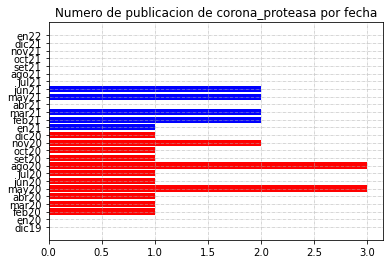

In [140]:
for i ,j in zip(fecha_ddf, color):
    plt.barh(i,df_dates_df.loc[i,"value"],color=j)

plt.title("Numero de publicacion de corona_proteasa por fecha")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

In [66]:
df_filtro_estudio["title"][0]

'Tellurium: A Rare Element with Influence on Prokaryotic and Eukaryotic Biological Systems'

In [127]:
print("corona_proteasa: ", df_filtro_estudio.shape[0])

corona_proteasa:  28


##### molecular_docking_simulation

In [141]:
filtros_estudio = {
    "molecular_docking_simulation":[
        "Molecular Docking Simulation",
        "Molecular Docking Simulations",
        "Molecular Docking",
        "Molecular Dockings",
        "Molecular Docking Analysis",
        "Molecular Docking Analyses"
    ],
    "molecular_dynamics_simulation":[
        "Molecular Dynamics Simulation",
        "Molecular Dynamics Simulations",
        "Molecular Dynamics",
        "Molecular Dynamic"
    ],
    "pharmacokinetics":[ 
        "Pharmacokinetics",
        "Drug Kinetics",
        "ADMET",
        "ADME-Tox",
        "Absorption, Distribution, Metabolism, Elimination, and Toxicology",
        "LADMER",
        #"potential"
    ]
}


In [142]:
orden_filtros = {
    0:"molecular_docking_simulation", 
    1:"molecular_dynamics_simulation", 
    2:"pharmacokinetics"
}

filtro1_estudio = [0]

In [143]:
for i,j in zip(filtros_estudio.keys(),list(map(lambda x: [i.lower() for i in x] , filtros_estudio.values()))):
    filtros_estudio[i]=j

In [144]:
filtro_estudio_list = list(funcion_filtro_estudio(df_filtro_covid.body_x, df_filtro_covid.title, filtro1_estudio))  
filtro1_list_unzip = list(zip(*filtro_estudio_list))
df1 = dict()

df1["title"] = filtro1_list_unzip[1]
df_t = pd.DataFrame(df1)["title"]
df_filtro_estudio = pd.merge(df_t, df_filtro_covid)
df_filtro_estudio.shape

tabla = df_filtro_estudio
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_estudio = pd.DataFrame(title_unique, columns=tabla.columns)
df_filtro_estudio.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
12,"1,2,3,4,6-Pentagalloyl Glucose, a RBD-ACE2 Bin...",cc-by,2021-03-04,Front Pharmacol,The worldwide pandemic Coronavirus disease 20...,Medline; PMC,Medline,0,0,0,1,0,1
52,Phytopharmaceuticals mediated Furin and TMPRSS...,no-cc,2020-10-28,Phytomedicine,The global data on severity and mortality of ...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
50,Phytogenic Products and Phytochemicals as a Ca...,cc-by,2020-10-20,Front Vet Sci,Since the emergence of the recent surpassing ...,Medline; PMC,Medline,0,0,0,1,0,1
48,"Phytoconstituents, In Vitro Anti-Infective Act...",cc-by,2021-04-12,Front Pharmacol,In spite of the great progress in the therape...,Medline; PMC,Medline,0,0,0,1,0,1
37,"Phytocompounds of Rheum emodi, Thymus serpyllu...",no-cc,2021-07-15,Curr Pharmacol Rep,Introduction COVID-19 caused by a member of f...,Medline; PMC,Medline,0,0,0,1,0,1


In [145]:
print("molecular_docking_simulation: ", df_filtro_estudio.shape[0])

molecular_docking_simulation:  1829


[]

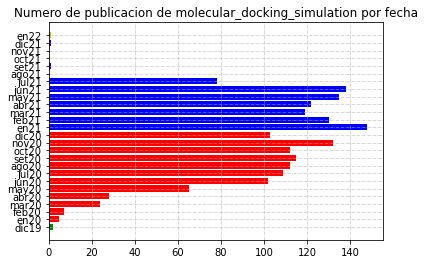

In [146]:
df_filtro_covid_mes_dic = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2019,12,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2019,12,31)))]
df_filtro_covid_mes_dic.shape[0]

l_meses2020 = []

for i in range(1,13):
    try:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,30)))].shape[0]])
    except:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,27)))].shape[0]])
        
l_meses2021 = []

for i in range(1,13):
    try:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,30)))].shape[0]])
    except:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,27)))].shape[0]])
        
df_filtro_covid_mes_ene22 = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2022,1,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2022,1,31)))]
df_filtro_covid_mes_ene22.shape[0]

dd = [df_filtro_covid_mes_dic.shape[0]]
dd.extend(list(map(lambda x: x[1],l_meses2020)))
dd.extend(list(map(lambda x: x[1],l_meses2021)))
dd.append(df_filtro_covid_mes_ene22.shape[0])
dd

dict_fechas = {'value' : dd,
'fecha': ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']
}

df_dates_df = pd.DataFrame(dict_fechas)
df_dates_df.head()

df_dates_df.rename(index=df_dates_df.fecha, inplace=True)

color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y']
fecha_ddf = ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']

for i ,j in zip(fecha_ddf, color):
    plt.barh(i,df_dates_df.loc[i,"value"],color=j)

plt.title("Numero de publicacion de molecular_docking_simulation por fecha")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

##### molecular_dynamics_simulation

In [152]:
orden_filtros = {
    0:"molecular_docking_simulation", 
    1:"molecular_dynamics_simulation", 
    2:"pharmacokinetics"
}

filtro1_estudio = [1]

In [153]:
filtro_estudio_list = list(funcion_filtro_estudio(df_filtro_covid.body_x, df_filtro_covid.title, filtro1_estudio))  
filtro1_list_unzip = list(zip(*filtro_estudio_list))
df1 = dict()

df1["title"] = filtro1_list_unzip[1]
df_t = pd.DataFrame(df1)["title"]
df_filtro_estudio = pd.merge(df_t, df_filtro_covid)
df_filtro_estudio.shape

tabla = df_filtro_estudio
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_estudio = pd.DataFrame(title_unique, columns=tabla.columns)
df_filtro_estudio

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
5,"1,2,3,4,6-Pentagalloyl Glucose, a RBD-ACE2 Bin...",cc-by,2021-03-04,Front Pharmacol,The worldwide pandemic Coronavirus disease 20...,Medline; PMC,Medline,0,0,0,1,0,1
21,Plant Antimicrobial Peptides: State of the Art...,cc-by-nc,2020-09-02,Bioinform Biol Insights,Proteins and peptides play different roles de...,Medline; PMC,Medline,0,0,0,1,0,1
22,Phytopharmaceuticals mediated Furin and TMPRSS...,no-cc,2020-10-28,Phytomedicine,The global data on severity and mortality of ...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
20,Phytochemicals from Selective Plants Have Prom...,cc-by,2020-10-13,Biomed Res Int,Coronaviruses have become a source of multipl...,Medline; PMC,Medline,0,0,0,1,0,1
19,Phytochemical Moieties From Indian Traditional...,cc-by,2021-05-07,Front Med (Lausanne),A new respiratory infectious disease was repo...,Medline; PMC,Medline,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1368,Exploration of Inhibitory Action of Azo imidaz...,no-cc,2020-08-31,J Mol Struct,After the outbreak of severe acute respirator...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
1367,Exploiting Knowledge on Structure–Activity Rel...,cc-by,2021-06-07,Biomedicines,Endogenous peptides are important mediators o...,Medline; PMC,Medline,0,0,0,1,0,1
1366,Expanding the Structural Diversity of DNA Meth...,cc-by,2020-12-27,Pharmaceuticals (Basel),"Historically, the term ""epigenetics"" is roote...",Medline; PMC,Medline,0,0,0,1,0,1
1365,Excavating SARS‐coronavirus 2 genome for epito...,no-cc,2020-07-09,J Cell Physiol,flu-like coronavirus which caused the recent ...,Medline; PMC,Medline,0,0,0,1,0,1


In [155]:
print("molecular_dynamics_simulation: ", df_filtro_estudio.shape[0])

molecular_dynamics_simulation:  1454


[]

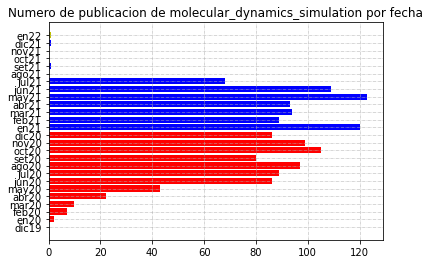

In [156]:
df_filtro_covid_mes_dic = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2019,12,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2019,12,31)))]
df_filtro_covid_mes_dic.shape[0]

l_meses2020 = []

for i in range(1,13):
    try:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,30)))].shape[0]])
    except:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,27)))].shape[0]])
        
l_meses2021 = []

for i in range(1,13):
    try:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,30)))].shape[0]])
    except:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,27)))].shape[0]])
        
df_filtro_covid_mes_ene22 = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2022,1,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2022,1,31)))]
df_filtro_covid_mes_ene22.shape[0]

dd = [df_filtro_covid_mes_dic.shape[0]]
dd.extend(list(map(lambda x: x[1],l_meses2020)))
dd.extend(list(map(lambda x: x[1],l_meses2021)))
dd.append(df_filtro_covid_mes_ene22.shape[0])
dd

dict_fechas = {'value' : dd,
'fecha': ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']
}

df_dates_df = pd.DataFrame(dict_fechas)
df_dates_df.head()

df_dates_df.rename(index=df_dates_df.fecha, inplace=True)

color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y']
fecha_ddf = ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']

for i ,j in zip(fecha_ddf, color):
    plt.barh(i,df_dates_df.loc[i,"value"],color=j)

plt.title("Numero de publicacion de molecular_dynamics_simulation por fecha")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

##### pharmacokinetics

In [157]:
filtro1_estudio = [2]

filtro_estudio_list = list(funcion_filtro_estudio(df_filtro_covid.body_x, df_filtro_covid.title, filtro1_estudio))  
filtro1_list_unzip = list(zip(*filtro_estudio_list))
df1 = dict()

df1["title"] = filtro1_list_unzip[1]
df_t = pd.DataFrame(df1)["title"]
df_filtro_estudio = pd.merge(df_t, df_filtro_covid)
df_filtro_estudio.shape

tabla = df_filtro_estudio
tabla_title = tabla[["title"]].value_counts().to_frame().reset_index()

title_unique = []

for i in range(tabla_title.shape[0]):
    aux_tabla = tabla[tabla["title"]==tabla_title.iloc[i,0]]
    
    len_aux_tabla = aux_tabla.shape[0]
    aux_tabla_comp = aux_tabla.iloc[0,:]
    
    count = 0
    
    for i in range(len_aux_tabla-1):
        if aux_tabla.iloc[i,:].equals(aux_tabla_comp):
            count+=1
    
    if count==(len_aux_tabla-1):
        title_unique.append(aux_tabla_comp)
        
df_filtro_estudio = pd.DataFrame(title_unique, columns=tabla.columns)
df_filtro_estudio

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,who,biorxiv,pmc,arxiv,medline
1473,"1,2,4 triazolo[1,5-a] pyrimidin-7-ones as nove...",no-cc,2020-09-22,Biophys Chem,"Affairs, the world economy could contract by ...",Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
34,Pharmacogenomics and Pharmacogenetics: In Sili...,cc-by-nc,2020-10-13,Pharmgenomics Pers Med,"Covid-19, an emergency all over the world, is...",Medline; PMC,Medline,0,0,0,1,0,1
9,"Pharmacokinetic, Pharmacodynamic, and Drug-Int...",cc-by-nc,2021-03-30,Clin Pharmacokinet,A clinical dosing regimen for the treatment o...,Medline; PMC,Medline,0,0,0,1,0,1
21,Pharmacokinetic modelling to estimate intracel...,no-cc,2021-06-02,J Antimicrob Chemother,The urgent global public health threat posed ...,Medline; PMC,Medline,0,0,0,1,0,1
14,Pharmacokinetic interactions between the poten...,no-cc,2021-07-15,J Zhejiang Univ Sci B,The coronavirus disease 2019 (COVID-19) pande...,Medline; PMC,Medline,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1714,Effect of Tenofovir Disoproxil Fumarate and Em...,no-cc,2021-06-27,EClinicalMedicine,Background: Tenofovir and emtricitabine inter...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
1720,Effect of TLR agonist on infections bronchitis...,no-cc,2020-02-14,Mol Immunol,Avian infectious bronchitis (IB) is a highly ...,Elsevier; Medline; PMC,Elsevier,1,0,0,1,0,1
1719,Effect of Systemic Inflammatory Response to SA...,medrxiv,2020-07-07,NaN,The release of inflammatory cytokines such as...,Medline; PMC,Medline,0,0,0,1,0,1
1718,Effect of Antioxidant Therapy on Oxidative Str...,cc-by,2021-02-25,Antioxidants (Basel),"Over the last few decades, many efforts have ...",Medline; PMC,Medline,0,0,0,1,0,1


In [158]:
print("pharmacokinetics: ", df_filtro_estudio.shape[0])

pharmacokinetics:  1748


[]

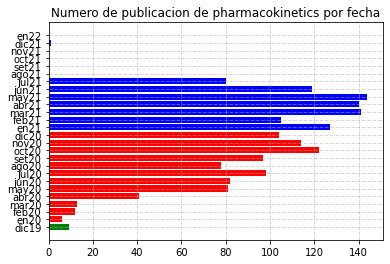

In [159]:
df_filtro_covid_mes_dic = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2019,12,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2019,12,31)))]
df_filtro_covid_mes_dic.shape[0]

l_meses2020 = []

for i in range(1,13):
    try:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,30)))].shape[0]])
    except:
        l_meses2020.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2020,i,27)))].shape[0]])
        
l_meses2021 = []

for i in range(1,13):
    try:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,30)))].shape[0]])
    except:
        l_meses2021.append([i, df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2021,i,27)))].shape[0]])
        
df_filtro_covid_mes_ene22 = df_filtro_estudio[((df_filtro_estudio["publish_time_x"] >= datetime(2022,1,1)) & (df_filtro_estudio["publish_time_x"] <= datetime(2022,1,31)))]
df_filtro_covid_mes_ene22.shape[0]

dd = [df_filtro_covid_mes_dic.shape[0]]
dd.extend(list(map(lambda x: x[1],l_meses2020)))
dd.extend(list(map(lambda x: x[1],l_meses2021)))
dd.append(df_filtro_covid_mes_ene22.shape[0])
dd

dict_fechas = {'value' : dd,
'fecha': ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']
}

df_dates_df = pd.DataFrame(dict_fechas)
df_dates_df.head()

df_dates_df.rename(index=df_dates_df.fecha, inplace=True)

color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y']
fecha_ddf = ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']

for i ,j in zip(fecha_ddf, color):
    plt.barh(i,df_dates_df.loc[i,"value"],color=j)

plt.title("Numero de publicacion de pharmacokinetics por fecha")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

#### Gráficacion de los campos de estudio obtenido

In [ ]:
!pip install matplotlib==3.4.1

In [70]:
import matplotlib

In [71]:
matplotlib.__version__

'3.4.1'

In [72]:
import matplotlib.pyplot as plt

In [161]:
result_estudio_f = {
        "molecular_docking_simulation":  1829,
        "molecular_dynamics_simulation":  1454,
        "pharmacokinetics":  1748,
        "corona_proteasa": 28
    }


In [162]:
import numpy as np

In [163]:
result_estudio_f_df = pd.DataFrame(result_estudio_f.values(), columns=["Campos de filtro"] , index=result_estudio_f.keys())
result_estudio_f_df.head()

,Campos de filtro
molecular_docking_simulation,1829
molecular_dynamics_simulation,1454
pharmacokinetics,1748
corona_proteasa,28


[]

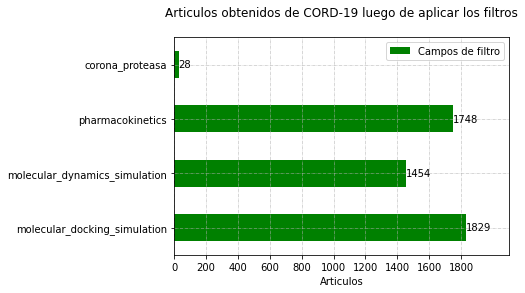

In [164]:
ax = result_estudio_f_df.plot.barh(color='g')
ax.bar_label(ax.containers[0])

plt.title("Articulos obtenidos de CORD-19 luego de aplicar los filtros\n")
plt.grid(True,linestyle="-.", linewidth=0.5)
plt.xlabel("Articulos")
plt.xticks(np.arange(0, 2000, 200))
ax.set_xlim(0,2100)
plt.plot()

# Diagrama de filtración

In [165]:
from graphviz import Digraph
import graphviz 
from IPython.display import display

pri = Digraph(format='png')

with pri.subgraph() as c:
    c.attr(rank='same')
    c.node('a', 'Total de estudios en formato json de CORD-19 (directorios /pdf_json y /pmc_json)', shape='box')
    c.node('b', 'Total de estudios de los articulos de CORD-19 (metadata.csv)', shape='box')
pri.node('c', '# de estudios que tuvieron como contenido cualquiera de las palabras y/o sinónimos de: \n corona_proteasa, molecular_docking_simulation, molecular_dynamics_simulation, machine_learning, deep_learning,  pharmacokinetics', shape='box')

#with pri.subgraph() as c:
#c.attr(rank='same')
pri.node('d', '# de estudios que tuvieron match entre los json y metadata', shape='box')
pri.node('e', '# de estudios publicados desde diciembre del 2019', shape='box')
    
#with pri.subgraph() as c:
pri.attr(rank='same')
pri.node('f', '# de estudios que tuvieron como contenido COVID-19', shape='box')
pri.node('g', '# de estudios que tuvieron que no contuvieran los terminos y/o sinónimos: \n machine_learning, deep_learning', shape='box')
    
#with pri.subgraph() as c:
#pri.attr(rank='same')
#pri.node('h', '# de estudios que tuvieron como contenido molecular_docking_simulation y/o sinónimos', shape='box')
#pri.node('i', '# de estudios que tuvieron como contenido molecular_dynamics_simulation y/o sinónimos', shape='box')
#pri.node('j', '# de estudios que tuvieron como contenido pharmacokinetics y/o sinónimos', shape='box')
pri.node('k', 'final # de estudios incluidos en el análisis', shape='box')

#pri.edges(['ac', 'bd', 'cd', 'de','ef','fg','gh','hi','ij'])
pri.edge('a', 'c', label="430975")#, constraint="true", style="invis")
pri.edge('b', 'd', label="740302")
pri.edge('c', 'd', label="19285")
pri.edge('d', 'e', label="10749")
pri.edge('e', 'f', label="4356")
pri.edge('f', 'g', label="3790")
pri.edge('g', 'k', label="3777")


#display(graphviz.Source(pri.source))
pri.render(view=True)

'Digraph.gv.png'

In [166]:
pri2 = Digraph(format='png')

pri2.node('h', '# de estudios que tuvieron como contenido \n molecular_docking_simulation y/o sinónimos', shape='box')
pri2.node('i', '# de estudios que tuvieron como contenido \n molecular_dynamics_simulation y/o sinónimos', shape='box')
pri2.node('j', '# de estudios que tuvieron como contenido \n pharmacokinetics y/o sinónimos', shape='box')
pri2.node('k', 'final # de estudios incluidos en el análisis', shape='box')

pri2.edge('k', 'h', label="1829")
pri2.edge('k', 'i', label="1454")
pri2.edge('k', 'j', label="1748")

pri2.render(view=True)

'Digraph.gv.png'

In [167]:
#l = glob("./**/*body_filtro2*.csv")

In [168]:
#import re

In [169]:
#reduce(lambda x,y: int(x)+int(y), list(map(lambda x: re.findall(r"(\d+\b).csv",x)[0],l)))

## Métricas obtenidas

* gráfica de aceptados
* fechas de aceptados, recibidos y publicados
* Gráfica de paises y idioma
* Gráfica de afiliación a paises.
* Gráfica de autores
* Gráfica de citación por publicación

### Source

In [170]:
df_filtro_final_filtro.elsevier.sum()

737

In [171]:
df_filtro_final_filtro.medline.sum()

3535

In [172]:
df_filtro_final_filtro.biorxiv.sum()

9

In [173]:
df_filtro_final_filtro.pmc.sum()

3777

### journal

In [174]:
df_journal = df_filtro_final_filtro.journal_x.value_counts()[df_filtro_final_filtro.journal_x.value_counts()>20]
df_journal

Journal of biomolecular structure & dynamics    176
Molecules                                       141
Int J Mol Sci                                   116
Front Pharmacol                                  95
Viruses                                          66
J Biomol Struct Dyn                              65
Sci Rep                                          63
Front Mol Biosci                                 48
PLoS One                                         45
Pharmaceuticals (Basel)                          45
Front Immunol                                    37
J Mol Struct                                     37
Mol Divers                                       36
Brief Bioinform                                  33
Pharmaceutics                                    31
Biomolecules                                     29
Comput Biol Med                                  28
bioRxiv                                          28
Front Chem                                       27
Comput Struc

In [175]:
pd.DataFrame({"Publicación por Journal":df_journal})

,Publicación por Journal
Journal of biomolecular structure & dynamics,176
Molecules,141
Int J Mol Sci,116
Front Pharmacol,95
Viruses,66
J Biomol Struct Dyn,65
Sci Rep,63
Front Mol Biosci,48
PLoS One,45
Pharmaceuticals (Basel),45


[]

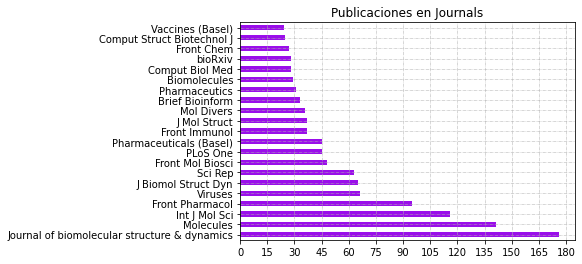

In [176]:
df_journal.plot.barh(color="#9A0EEA")
plt.title("Publicaciones en Journals")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
plt.xticks(np.arange(0, 210, 15))
plt.plot()

<AxesSubplot:>

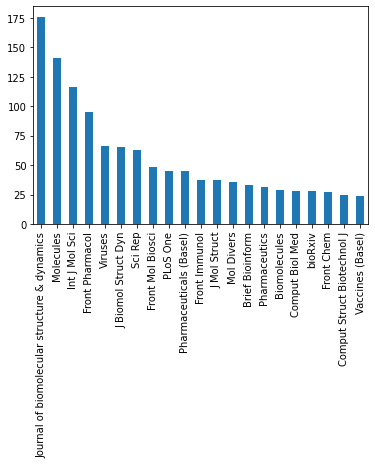

In [177]:
df_journal.plot.bar()

### idioma

In [93]:
!pip install langdetect

Defaulting to user installation because normal site-packages is not writeable


In [178]:
from langdetect import detect

In [179]:
def detect_lang(text):
    return detect(text)

df_filtro_final_filtro["lang"] = df_filtro_final_filtro["body_x"].apply(detect_lang)

In [180]:
df_filtro_final_filtro.lang.value_counts()

en    3769
fr       8
Name: lang, dtype: int64

In [181]:
pd.DataFrame({"Lenguaje de articulos": df_filtro_final_filtro.lang.value_counts()})

,Lenguaje de articulos
en,3769
fr,8


[]

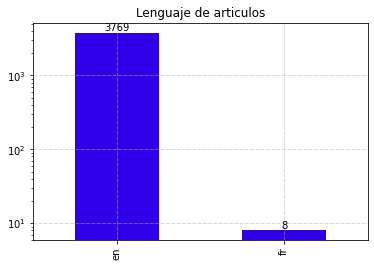

In [182]:
ax = df_filtro_final_filtro.lang.value_counts().plot.bar(logy=True,color="#3100E9")
ax.bar_label(ax.containers[0])

plt.title("Lenguaje de articulos")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

<AxesSubplot:>

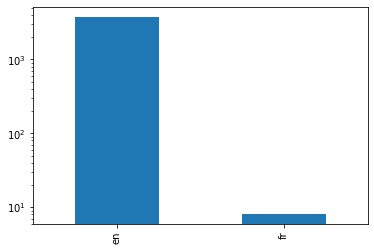

In [99]:
df_filtro_final_filtro.lang.value_counts().plot.bar(logy=True)

## Numero de publicacion de covid por fecha

In [100]:
df_filtro_covid["publish_time_x"].max()

Timestamp('2022-01-01 00:00:00')

In [101]:
df_filtro_covid["publish_time_x"].min()

Timestamp('2019-12-01 00:00:00')

In [102]:
df_filtro_covid.shape

(3790, 13)

In [103]:
df_filtro_covid.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,biorxiv,who,arxiv,medline,pmc
2231,Tellurium: A Rare Element with Influence on Pr...,cc-by,2021-05-31,Int J Mol Sci,Tellurium (Te) is a member of the chalcogen g...,Medline; PMC,Medline,0,0,0,0,1,1
116,Potential therapeutic target identification in...,cc-by,2020-10-02,Egypt J Med Hum Genet,The first outburst of pneumonia cases with un...,PMC,PMC,0,0,0,0,0,1
2889,Antiviral Activity Exerted by Natural Products...,cc-by,2021-05-04,Viruses,A growing number of studies have shown the be...,Medline; PMC,Medline,0,0,0,0,1,1
790,Molecular targets for COVID-19 drug developmen...,no-cc,2020-07-09,Biosaf Health,There is little or no research initiated to e...,Elsevier; Medline; PMC,Elsevier,1,0,0,0,1,1
3407,Learning from the Past: Possible Urgent Preven...,no-cc,2020-02-25,Chembiochem,The 2019 novel coronavirus (2019-nCoV) is an ...,Medline; PMC,Medline,0,0,0,0,1,1


In [104]:
df_filtro_covid_mes_dic = df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2019,12,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2019,12,31)))]
df_filtro_covid_mes_dic.shape[0]

11

In [105]:
l_meses2020 = []

for i in range(1,13):
    try:
        l_meses2020.append([i, df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2020,i,30)))].shape[0]])
    except:
        l_meses2020.append([i, df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2020,i,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2020,i,27)))].shape[0]])

In [106]:
l_meses2020

[[1, 11],
 [2, 24],
 [3, 41],
 [4, 78],
 [5, 153],
 [6, 194],
 [7, 218],
 [8, 221],
 [9, 214],
 [10, 248],
 [11, 250],
 [12, 212]]

In [107]:
l_meses2021 = []

for i in range(1,13):
    try:
        l_meses2021.append([i, df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2021,i,30)))].shape[0]])
    except:
        l_meses2021.append([i, df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2021,i,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2021,i,27)))].shape[0]])

In [108]:
l_meses2021

[[1, 291],
 [2, 252],
 [3, 274],
 [4, 263],
 [5, 300],
 [6, 281],
 [7, 166],
 [8, 0],
 [9, 1],
 [10, 0],
 [11, 0],
 [12, 1]]

In [109]:
df_filtro_covid_mes_ene22 = df_filtro_covid[((df_filtro_covid["publish_time_x"] >= datetime(2022,1,1)) & (df_filtro_covid["publish_time_x"] <= datetime(2022,1,31)))]
df_filtro_covid_mes_ene22.shape[0]

1

In [110]:
dd = [df_filtro_covid_mes_dic.shape[0]]
dd.extend(list(map(lambda x: x[1],l_meses2020)))
dd.extend(list(map(lambda x: x[1],l_meses2021)))
dd.append(df_filtro_covid_mes_ene22.shape[0])
dd

[11,
 11,
 24,
 41,
 78,
 153,
 194,
 218,
 221,
 214,
 248,
 250,
 212,
 291,
 252,
 274,
 263,
 300,
 281,
 166,
 0,
 1,
 0,
 0,
 1,
 1]

In [111]:
dict_fechas = {'value' : dd,
'fecha': ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']
}

In [112]:
df_dates_df = pd.DataFrame(dict_fechas)
df_dates_df.head()

,value,fecha
0,11,dic19
1,11,en20
2,24,feb20
3,41,mar20
4,78,abr20


<AxesSubplot:>

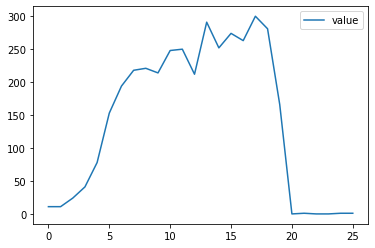

In [113]:
df_dates_df.plot()

<AxesSubplot:>

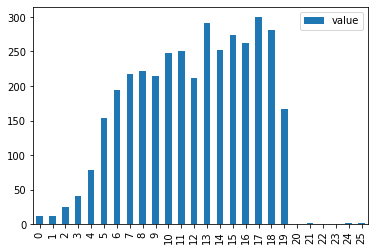

In [114]:
df_dates_df.plot.bar(lw=2)

<AxesSubplot:>

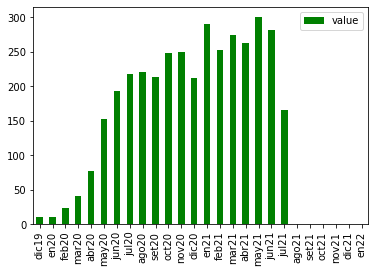

In [115]:
df_dates_df.rename(index=df_dates_df.fecha).plot.bar(color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y'])

In [116]:
df_dates_df.rename(index=df_dates_df.fecha, inplace=True)

In [117]:
df_dates_df

,value,fecha
dic19,11,dic19
en20,11,en20
feb20,24,feb20
mar20,41,mar20
abr20,78,abr20
may20,153,may20
jun20,194,jun20
jul20,218,jul20
ago20,221,ago20
set20,214,set20


In [118]:
import matplotlib.pyplot as plt

In [119]:
color=['g','r','r','r','r','r','r','r','r','r','r','r','r','b','b','b','b','b','b','b','b','b','b','b','b','y']
fecha_ddf = ['dic19','en20','feb20','mar20','abr20','may20','jun20','jul20','ago20','set20','oct20','nov20','dic20'  ,'en21','feb21','mar21','abr21','may21','jun21','jul21','ago21','set21','oct21','nov21','dic21','en22']

[]

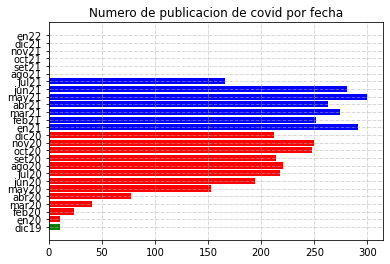

In [120]:
for i ,j in zip(fecha_ddf, color):
    plt.barh(i,df_dates_df.loc[i,"value"],color=j)

plt.title("Numero de publicacion de covid por fecha")
plt.grid(True,linestyle="-.", linewidth=0.5)
#plt.xlabel("")
#plt.xticks(np.arange(0, 210, 15))
plt.plot()

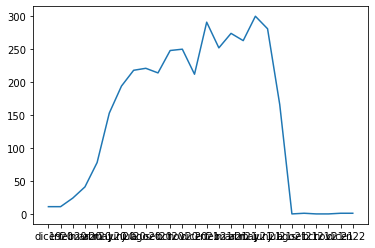

In [121]:
plt.plot(df_dates_df.loc[:,"value"])
#plt.grid(True)

### Licence

In [122]:
pd.DataFrame({"Licencias":df_filtro_covid.license_x.value_counts()})

,Licencias
no-cc,1774
cc-by,1691
cc-by-nc,160
cc-by-nc-nd,82
els-covid,35
biorxiv,25
cc-by-nc-sa,16
cc0,4
medrxiv,2
arxiv,1


[]

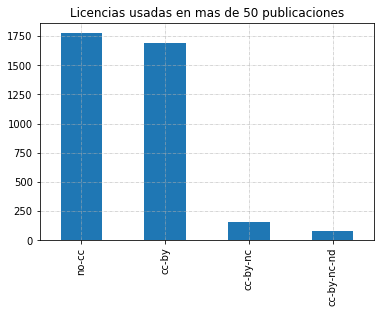

In [123]:
df_filtro_covid.license_x.value_counts()[df_filtro_covid.license_x.value_counts()>50].plot.bar()
plt.title("Licencias usadas en mas de 50 publicaciones")
plt.grid(True,linestyle="-.", linewidth=0.5)
plt.plot()

# NLP

In [124]:
df_filtro_covid.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,biorxiv,who,arxiv,medline,pmc
2231,Tellurium: A Rare Element with Influence on Pr...,cc-by,2021-05-31,Int J Mol Sci,Tellurium (Te) is a member of the chalcogen g...,Medline; PMC,Medline,0,0,0,0,1,1
116,Potential therapeutic target identification in...,cc-by,2020-10-02,Egypt J Med Hum Genet,The first outburst of pneumonia cases with un...,PMC,PMC,0,0,0,0,0,1
2889,Antiviral Activity Exerted by Natural Products...,cc-by,2021-05-04,Viruses,A growing number of studies have shown the be...,Medline; PMC,Medline,0,0,0,0,1,1
790,Molecular targets for COVID-19 drug developmen...,no-cc,2020-07-09,Biosaf Health,There is little or no research initiated to e...,Elsevier; Medline; PMC,Elsevier,1,0,0,0,1,1
3407,Learning from the Past: Possible Urgent Preven...,no-cc,2020-02-25,Chembiochem,The 2019 novel coronavirus (2019-nCoV) is an ...,Medline; PMC,Medline,0,0,0,0,1,1


In [125]:
df_filtro_covid.shape

(3790, 13)

In [126]:
!pip install matplotlib pandas nltk textblob 

Defaulting to user installation because normal site-packages is not writeable


#### NLTK: Natural Language Tooklit

[Natural Language Toolkit](https://www.nltk.org/) is the basis for a lot of text analysis done in Python. It's old and terrible and slow, but it's just been used for so long and does so many things that it's generally the default when people get into text analysis. The new kid on the block is [spaCy](https://spacy.io/) (but it doesn't do sentiment analysis out of the box so we're leaving it out of this).

When you first run NLTK, you need to download some datasets to make sure it will be able to do everything you want.

In [127]:
import nltk
nltk.download('vader_lexicon')
nltk.download('movie_reviews')
nltk.download('punkt')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/stevend/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /home/stevend/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /home/stevend/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [128]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA

sia = SIA()
sia.polarity_scores("This restaurant was great, but I'm not sure if I'll go there again.")

{'neg': 0.153, 'neu': 0.688, 'pos': 0.159, 'compound': 0.0276}

Asking `SentimentIntensityAnalyzer` for the `polarity_score` gave us four values in a dictionary:

- **negative:** the negative sentiment in a sentence
- **neutral:** the neutral sentiment in a sentence
- **positive:** the postivie sentiment in the sentence
- **compound:** the aggregated sentiment. 
    
Seems simple enough!

In [129]:
text = "I just got a call from my boss - does he realise it's Saturday?"
sia.polarity_scores(text), type(sia.polarity_scores(text))

({'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}, dict)

In [130]:
def df_filtro_covid_def_pol(f):
    return sia.polarity_scores(f)

df_filtro_covid["polarity"] = df_filtro_covid.body_x.apply(df_filtro_covid_def_pol)

In [131]:
df_filtro_covid.head()

,title,license_x,publish_time_x,journal_x,body_x,source_x_y,source_medline,elsevier,biorxiv,who,arxiv,medline,pmc,polarity
2231,Tellurium: A Rare Element with Influence on Pr...,cc-by,2021-05-31,Int J Mol Sci,Tellurium (Te) is a member of the chalcogen g...,Medline; PMC,Medline,0,0,0,0,1,1,"{'neg': 0.045, 'neu': 0.902, 'pos': 0.053, 'co..."
116,Potential therapeutic target identification in...,cc-by,2020-10-02,Egypt J Med Hum Genet,The first outburst of pneumonia cases with un...,PMC,PMC,0,0,0,0,0,1,"{'neg': 0.023, 'neu': 0.899, 'pos': 0.079, 'co..."
2889,Antiviral Activity Exerted by Natural Products...,cc-by,2021-05-04,Viruses,A growing number of studies have shown the be...,Medline; PMC,Medline,0,0,0,0,1,1,"{'neg': 0.074, 'neu': 0.85, 'pos': 0.076, 'com..."
790,Molecular targets for COVID-19 drug developmen...,no-cc,2020-07-09,Biosaf Health,There is little or no research initiated to e...,Elsevier; Medline; PMC,Elsevier,1,0,0,0,1,1,"{'neg': 0.052, 'neu': 0.875, 'pos': 0.073, 'co..."
3407,Learning from the Past: Possible Urgent Preven...,no-cc,2020-02-25,Chembiochem,The 2019 novel coronavirus (2019-nCoV) is an ...,Medline; PMC,Medline,0,0,0,0,1,1,"{'neg': 0.042, 'neu': 0.892, 'pos': 0.066, 'co..."


In [132]:
df_filtro_covid["pol_neg"] = df_filtro_covid.polarity.apply(lambda x: x["neg"])
df_filtro_covid["pol_neu"] = df_filtro_covid.polarity.apply(lambda x: x["neu"])
df_filtro_covid["pol_pos"] = df_filtro_covid.polarity.apply(lambda x: x["pos"])

In [133]:
df_filtro_covid["pol_neg"][df_filtro_covid["pol_neg"]>0.5].count()

0

In [134]:
df_filtro_covid["pol_neu"][df_filtro_covid["pol_neu"]>0.5].count()

3790

In [135]:
df_filtro_covid["pol_pos"][df_filtro_covid["pol_pos"]>0.5].count()

0

In [136]:
df_filtro_covid.title[0]

'Molecular modeling of potent novel sulfonamide derivatives as non-peptide small molecule anti-COVID 19 agents'